In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_feynmannd
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import dataset_miscnd
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 100
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 200
MAX_STREE_DEPTH  = 8
MAX_STREE_LENGTH = 20
GENERATIONS      = 25
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 20000
LIB_MAXDEPTH  = 3 #5
LIB_MAXLENGTH = 10 #15

BACKPROP_TRIALS = 2

RANDSTATE = 124

In [3]:
randstate.setstate(RANDSTATE)

S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc3d.Resistance3()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.RocketFuelFlow()
#S = dataset_physics.AircraftLift()
#S = dataset_misc2d.Pagie1()
#S = dataset_miscnd.WavePower()
#S = dataset_feynmannd.FeynmanIICh6Eq15a()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
import profiling
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

const_prob = 0.0 if S.knowledge.has_symmvars() else 0.5
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, const_prob=const_prob)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp_mutator.NumericParameterMutator(all=False)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
data_evaluator = gp_evaluator.R2Evaluator(S_train, linscale=False)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, data_evaluator, know_pressure=1.0)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)
#corrector.backprop_trials = BACKPROP_TRIALS

settings = gp.GPSettings(
      POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
      creator=solutionCreator,
      evaluator=evaluator,
      selector=selector,
      crossover=crossover,
      mutator=multiMutator,
      corrector=corrector,
      mutrate=MUTATION_RATE,
      elitism=ELITISM,
      knowledge=S.knowledge)
symb_regressor = gp.GP(settings)
#symb_regressor = gp.MOGP(settings)

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

  0%|          | 0/24 [00:00<?, ?it/s]

         4924225 function calls (4733829 primitive calls) in 7.734 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.299    0.299    7.734    7.734 clibrary.py:9(__init__)
        1    0.657    0.657    6.557    6.557 library.py:128(__init__)
        2    0.131    0.065    3.708    1.854 creator.py:124(create_population)
    48343    0.486    0.000    2.841    0.000 creator.py:63(ptc2)
   131754    0.427    0.000    1.478    0.000 creator.py:43(createRandomNonTerminal)
    18865    0.059    0.000    0.726    0.000 _methods.py:267(_std)
    18865    0.451    0.000    0.666    0.000 _methods.py:198(_var)
123333/75735    0.133    0.000    0.642    0.000 unaop.py:53(simplify)
87759/54108    0.138    0.000    0.642    0.000 binop.py:62(simplify)
   284685    0.529    0.000    0.639    0.000 syntax_tree.py:67(__init__)
   100560    0.172    0.000    0.567    0.000 creator.py:38(createRandomTerminal)
49550/31993    

In [5]:
test_data_evaluator = gp_evaluator.R2Evaluator(S_test)
best_stree.clear_output()
print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
print(f"Test R2: {test_data_evaluator.evaluate(best_stree).value}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")


--- Best syntax tree ---
((x0 * 1.01) / ((square((0.12 + square(x0))) / -0.71) / 0.28))
fea: 1.0
R²: 0.9993591258629774
Max depth: 6
Length: 13
Test R2: 0.9986660586018811


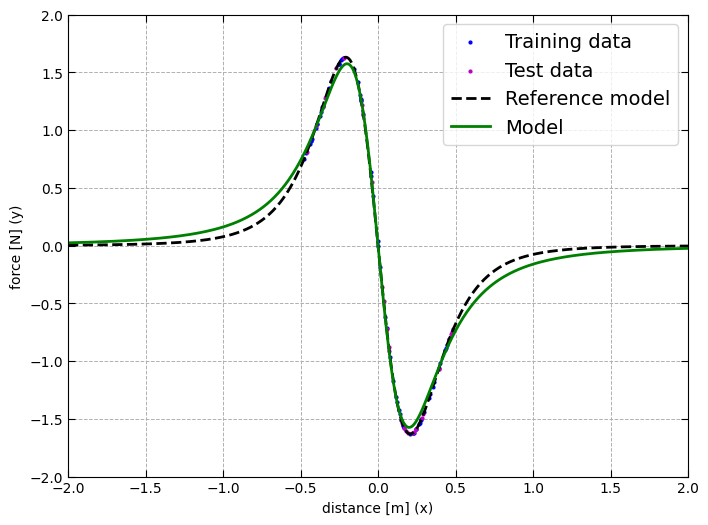

{'mse': 0.00384285327708141, 'rmse': 0.061990751544737786, 'r2': 0.9903092441316864}
(184, 0)


In [6]:
best_stree.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
print(S.evaluate_extra(best_stree))
print(know_evaluator.evaluate(best_stree))

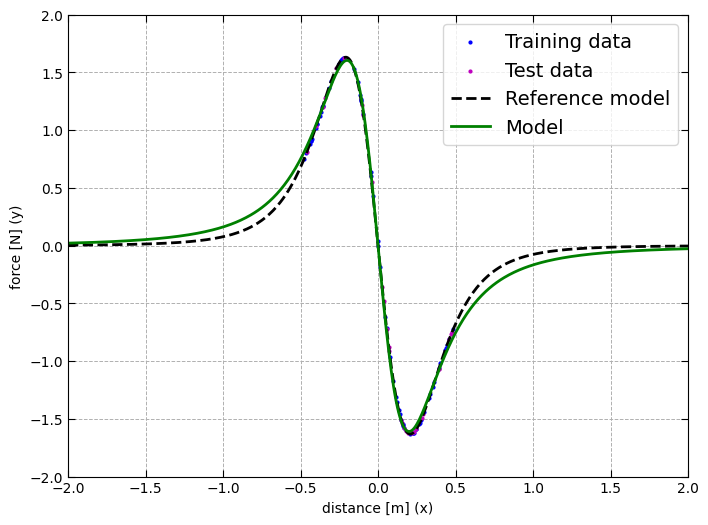

Test R2: 0.9990405284559767


In [7]:
best_stree.clear_output()
scaler = gp_evaluator.LinearScaler(S_train.y)
best_stree_scaled = scaler.scale_stree(best_stree, best_stree(S_train.X))
best_stree_scaled.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree_scaled, zoomout=1)

best_stree_scaled.clear_output()
print(f"Test R2: {test_data_evaluator.evaluate(best_stree_scaled).value}")

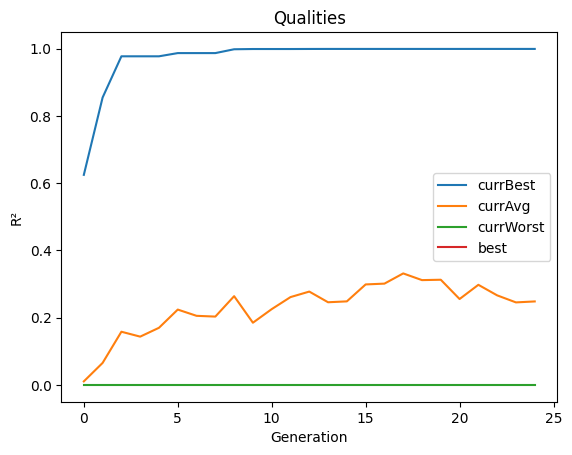

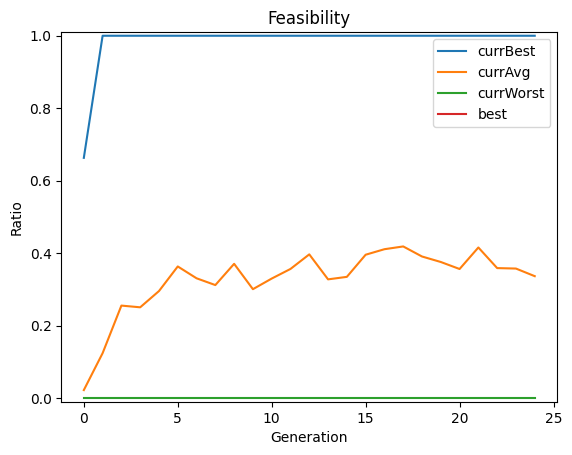

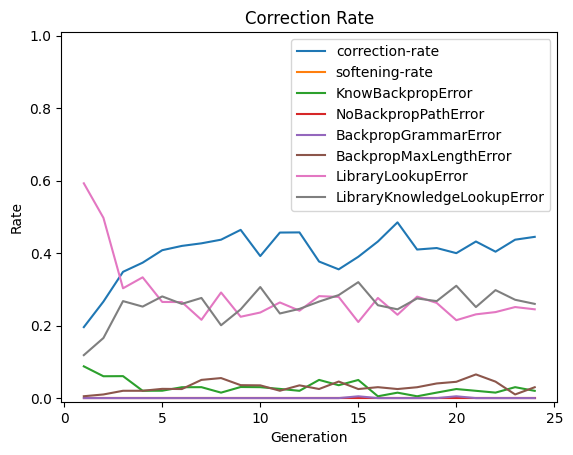

In [8]:
symb_regressor.stats.plot()

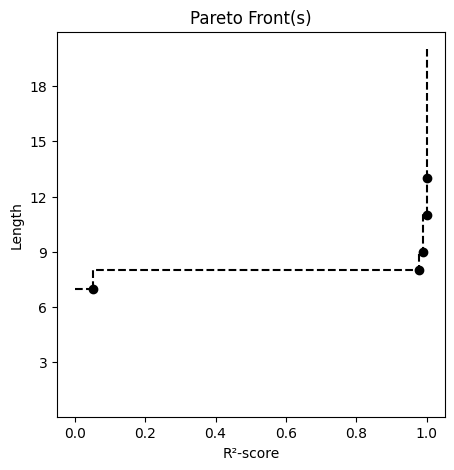

Feasibility Ratio: 1.0
Extent of Convergence: 0.6316448030408274


,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,((0.08 / (x0 + 0.01)) * -0.12),0,0.034590,0.053215,7,(/),1,inf
1,1,((x0 * 1.01) / ((square((0.12 + square(x0))) /...,0,0.349776,0.999359,13,"(/, square)",4,inf
2,2,(x0 / ((-0.05 - square(x0)) * 1.55)),0,0.587295,0.978825,8,"(/, square)",4,1.321244
3,3,((x0 * 0.28) / (square((0.12 + square(x0))) / ...,0,0.449518,0.998928,11,"(/, square)",4,0.678756
4,4,(x0 / (0.86 - square((0.96 + square(x0))))),0,0.543356,0.987921,9,"(/, square)",4,0.521248


In [9]:
pd_data = []
front_tracker, fea_ratio = symb_regressor.fea_front_tracker.get_head(0)

for frontidx in range(len(front_tracker.front)):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

data_lu = (0.0,1.0)
length_lu = (1,MAX_STREE_LENGTH)

front_tracker.plot(data_lu, length_lu, [0])
print(f"Feasibility Ratio: {fea_ratio}")
print(f"Extent of Convergence: {front_tracker.compute_extend_of_convergence(data_lu, length_lu)}")
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)